## Task 1 - Part 1

#### Step 1 − Import the necessary packages

In [562]:
# Importar bibliotecas necessárias
import numpy as np
import random
import matplotlib.pyplot as plt  # Corrigido plt00 para plt
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor, LinearRegression  # Unificado as importações do sklearn.linear_model
from sklearn.model_selection import GridSearchCV, train_test_split  # Unificado imports de model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels import robust  # statsmodels não conflita com sklearn, então permanece
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam


    


#### Step 1.5 − Picture visulazer

In [563]:
# Função para visualizar as imagens
def img_view (dataset, labels=None, num_imgs=5):
    """
    Função que visualiza um número especificado de imagens.
    
    Parâmetros:
    - dataset: Conjunto de imagens a visualizar.
    - labels: (Opcional) Rótulos das imagens, se disponíveis.
    - num_imgs: Número de imagens a visualizar.
    """
    # Verificar quantas imagens existem no dataset
    num_imgs = min(num_imgs, len(dataset))  # Garante que não tentas visualizar mais imagens do que as disponíveis

    # Criar a figura para visualização
    plt.figure(figsize=(10, 10))
    
    for i in range(num_imgs):
        plt.subplot(1, num_imgs, i+1)
        plt.imshow(dataset[i], cmap='gray')  # Usar 'gray' para imagens em escala de cinza
        plt.axis('off')
        
        if labels is not None:
            plt.title(f"Label: {labels[i]}")

    plt.show()

#### Step 2 − Load the dataset

X_train shape antes do reshape: (2783, 2304)
X_train shape depois do reshape: (2783, 48, 48)


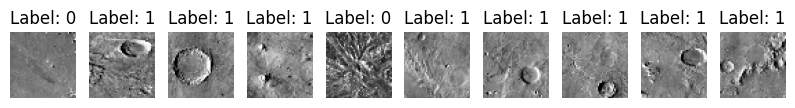

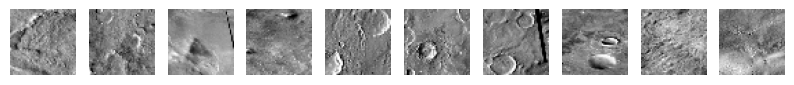

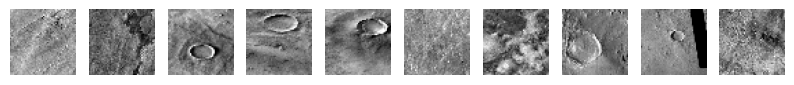

In [564]:
# Carregar os dados
X_test = np.load('Xtest1.npy')
X_train = np.load('Xtrain1.npy')
Y_train = np.load('Ytrain1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

# Verificar as dimensões dos datasets antes do reshape
print(f"X_train shape antes do reshape: {X_train.shape}")

# Reformatar as imagens para o formato correto (48, 48)
X_train = X_train.reshape(-1, 48, 48)
X_test = X_test.reshape(-1, 48, 48)
X_train_extra = X_train_extra.reshape(-1, 48, 48)

print(f"X_train shape depois do reshape: {X_train.shape}")
#############################################3
# Variável para controlar quantas imagens queres visualizar
num_imagens = 10  # Podes alterar este número para visualizar mais ou menos imagens
#######################################3


# Visualizar imagens de treino com rótulos
img_view(X_train, Y_train, num_imgs=num_imagens)

# Visualizar imagens de teste (sem rótulos)
img_view(X_test, num_imgs=num_imagens)

# Visualizar imagens do dataset extra (sem rótulos)
img_view(X_train_extra, num_imgs=num_imagens)


#### Step 2.5 - processamento

In [565]:
# 2. Preprocessamento: Reshape e Normalização
# Ajustar a forma das imagens para (48, 48, 1) para incluir o canal de cor (grayscale)
# A CNN espera 4 dimensões: (número de amostras, altura, largura, número de canais)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Normalizar os valores dos píxeis para estar entre 0 e 1, dividindo por 255
# Isto ajuda o modelo a convergir melhor durante o treino
X_train = X_train / 255.0
X_test = X_test / 255.0

# Verificar novamente a forma após o reshape
print(f"Forma de X_train depois do reshape: {X_train.shape}")
print(f"Forma de X_test depois do reshape: {X_test.shape}")

# Dividir o conjunto de treino em treino e validação (20% dos dados para validação)
# O conjunto de validação é usado para verificar a performance do modelo durante o treino
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


Forma de X_train depois do reshape: (2783, 48, 48, 1)
Forma de X_test depois do reshape: (696, 48, 48, 1)


#### Step 2.5 - Balancing the dataset

In [566]:
#RANDOM OVERSAMPLER (OVERSAMPLES MINORITY CLASS)

X_train_flat = X_train.reshape(X_train.shape[0], -1)

ros = RandomOverSampler(random_state=42)
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train_flat, Y_train)

X_train_resampled = X_train_resampled.reshape(-1, 48, 48, 1)



#### Step 3 −Definir a arquitetura da cnn 

In [567]:
# 3. Definir a CNN (Convolutional Neural Network)
# Modelo sequencial permite adicionar camadas uma após a outra
model_orig = Sequential()

# Primeira camada convolucional:
# - 32 filtros (kernels) de 3x3
# - Função de ativação 'ReLU' (Rectified Linear Unit)
# - Input shape é 48x48 com 1 canal (grayscale)
model_orig.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
# MaxPooling reduz a dimensionalidade: Reduz o tamanho da imagem de 48x48 para 24x24
model_orig.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda camada convolucional:
# - 64 filtros de 3x3
# - MaxPooling reduz ainda mais a dimensão para 12x12
model_orig.add(Conv2D(64, (3, 3), activation='relu'))
model_orig.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira camada convolucional:
# - 128 filtros de 3x3
# - MaxPooling reduz para 6x6
model_orig.add(Conv2D(128, (3, 3), activation='relu'))
model_orig.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten: Converter as saídas convolucionais 3D em um vetor 1D para a camada totalmente conectada
model_orig.add(Flatten())

# Camada densa (fully connected):
# - 128 neurónios
# - Dropout com taxa de 50% para evitar overfitting
model_orig.add(Dense(128, activation='relu'))
model_orig.add(Dropout(0.5))  # Desativa aleatoriamente 50% dos neurónios durante o treino

# Camada de saída:
# - 1 neurónio com ativação 'sigmoid' (porque estamos a fazer classificação binária: crater ou não crater)
model_orig.add(Dense(1, activation='sigmoid'))


In [568]:
from tensorflow.keras import regularizers

# L2 regularization factor
l2_lambda = 0.01  # You can experiment with different values like 0.001, 0.01, etc. ANTES ESTAVA 0.001

# 3. Definir a CNN (Convolutional Neural Network)
# Modelo sequencial permite adicionar camadas uma após a outra
model_resampled = Sequential()

# Primeira camada convolucional:
# - 32 filtros (kernels) de 3x3 TENTANDO MENOS FILTROS
# - Função de ativação 'ReLU' (Rectified Linear Unit)
# - Input shape é 48x48 com 1 canal (grayscale)
model_resampled.add(Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 1),
                           kernel_regularizer=regularizers.l2(l2_lambda)))
# MaxPooling reduz a dimensionalidade: Reduz o tamanho da imagem de 48x48 para 24x24
model_resampled.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda camada convolucional:
# - 64 filtros de 3x3 TENTANDO MENOS FILTROS
# - MaxPooling reduz ainda mais a dimensão para 12x12
model_resampled.add(Conv2D(32, (3, 3), activation='relu', 
                           kernel_regularizer=regularizers.l2(l2_lambda)))
model_resampled.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira camada convolucional:
# - 128 filtros de 3x3 TENTANDO MENOS FILTROS
# - MaxPooling reduz para 6x6
model_resampled.add(Conv2D(64, (3, 3), activation='relu', 
                           kernel_regularizer=regularizers.l2(l2_lambda)))
model_resampled.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten: Converter as saídas convolucionais 3D em um vetor 1D para a camada totalmente conectada
model_resampled.add(Flatten())

# Camada densa (fully connected):
# - 128 neurónios TENTANDO MENOS
# - L2 regularização e Dropout com taxa de 50% para evitar overfitting
model_resampled.add(Dense(64, activation='relu', 
                          kernel_regularizer=regularizers.l2(l2_lambda)))
model_resampled.add(Dropout(0.7))  # Desativa aleatoriamente 50% dos neurónios durante o treino

# Camada de saída:
# - 1 neurónio com ativação 'sigmoid' (porque estamos a fazer classificação binária: crater ou não crater)
model_resampled.add(Dense(1, activation='sigmoid'))



####Step 3 - Compilar o modelo

In [569]:
# 4. Compilar o modelo
# - Otimizador 'adam': uma versão otimizada do gradiente descendente
# - Função de perda 'binary_crossentropy': apropriada para problemas de classificação binária
# - Métrica 'accuracy': avalia a percentagem de previsões corretas
# Monitor 'val_loss', stop training if no improvement for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_orig.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




# Define the learning rate reduction strategy
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, min_lr=0.000001)


optimizer = Adam(learning_rate=0.0001)
model_resampled.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


#### Step 4.1 - Treinar o modelo 

In [570]:
history_original = model_orig.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val))


Epoch 1/15
70/70 [==============================] - 2s 24ms/step - loss: 0.6281 - accuracy: 0.6339 - val_loss: 0.5283 - val_accuracy: 0.7846
Epoch 2/15
70/70 [==============================] - 2s 23ms/step - loss: 0.4842 - accuracy: 0.7996 - val_loss: 0.3954 - val_accuracy: 0.8492
Epoch 3/15
70/70 [==============================] - 2s 22ms/step - loss: 0.3753 - accuracy: 0.8437 - val_loss: 0.3600 - val_accuracy: 0.8510
Epoch 4/15
70/70 [==============================] - 1s 21ms/step - loss: 0.3125 - accuracy: 0.8760 - val_loss: 0.3531 - val_accuracy: 0.8618
Epoch 5/15
70/70 [==============================] - 2s 22ms/step - loss: 0.3058 - accuracy: 0.8765 - val_loss: 0.3205 - val_accuracy: 0.8707
Epoch 6/15
70/70 [==============================] - 2s 22ms/step - loss: 0.2561 - accuracy: 0.8931 - val_loss: 0.3270 - val_accuracy: 0.8851
Epoch 7/15
70/70 [==============================] - 1s 20ms/step - loss: 0.2381 - accuracy: 0.9052 - val_loss: 0.3021 - val_accuracy: 0.8815
Epoch 8/15
70

In [571]:
# 5. Treinar o modelo
# - Usamos o método .fit() para treinar o modelo nos dados de treino
# - Validação é monitorizada ao usar o conjunto de validação
# - O treino ocorre por 15 épocas com um batch size de 32 (pode-se ajustar esses valores)

# Create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_resampled.reshape(-1, 48, 48, 1))

learning_rates = []

class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        learning_rates.append(lr)


callbacks = [reduce_lr,early_stopping, LearningRateLogger()]


history_resampled = model_resampled.fit(
    datagen.flow(X_train_resampled.reshape(-1, 48, 48, 1), Y_train_resampled, batch_size=32),
    validation_data=(X_val, Y_val),
    steps_per_epoch=len(X_train_resampled) // 32,
    epochs=100,
    callbacks=callbacks
)

#history_resampled = model_resampled.fit(X_train_resampled, Y_train_resampled, epochs=15, batch_size=32, validation_data=(X_val, Y_val))

#history_resampled = model_resampled.fit(X_train_resampled, Y_train_resampled, epochs=15, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])
# O objeto "history" guarda a precisão e a perda de cada época, útil para gráficos
print("Learning rates during training:")
print(learning_rates)

Epoch 1/100
87/87 [==============================] - 2s 13ms/step - loss: 2.3199 - accuracy: 0.5061 - val_loss: 2.0802 - val_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 2/100
87/87 [==============================] - 1s 12ms/step - loss: 1.9136 - accuracy: 0.5101 - val_loss: 1.7319 - val_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 3/100
87/87 [==============================] - 1s 12ms/step - loss: 1.6061 - accuracy: 0.5122 - val_loss: 1.4625 - val_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 4/100
87/87 [==============================] - 1s 12ms/step - loss: 1.3753 - accuracy: 0.5273 - val_loss: 1.2643 - val_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 5/100
87/87 [==============================] - 1s 12ms/step - loss: 1.2022 - accuracy: 0.5327 - val_loss: 1.1154 - val_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 6/100
87/87 [==============================] - 1s 12ms/step - loss: 1.0716 - accuracy: 0.5316 - val_loss: 0.9955 - val_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 7/100
87/87 [===========================

#### Step 4 - With regularization


In [572]:
# 6. Avaliar o modelo no conjunto de teste
# - Usamos o método .evaluate() para testar o modelo nos dados não vistos
# - Ele retorna a perda e a métrica (neste caso, accuracy)
#test_loss, test_acc = model.evaluate(X_test, verbose=2)
#print(f"Test accuracy: {test_acc}")


#### Step 7 − View model


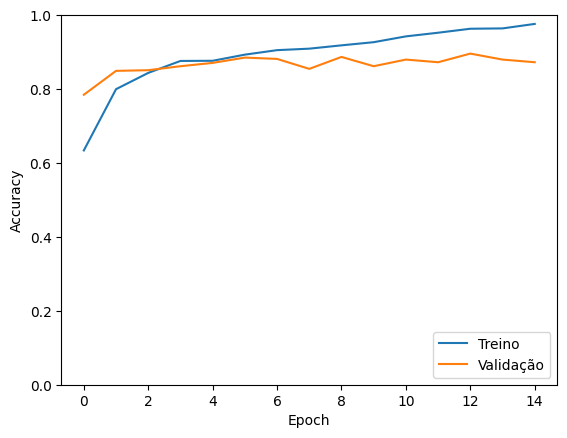

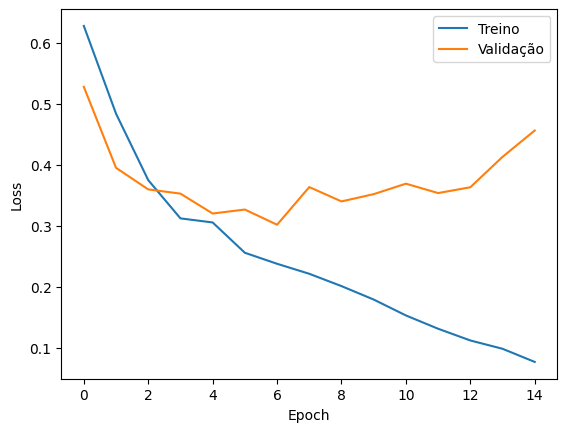

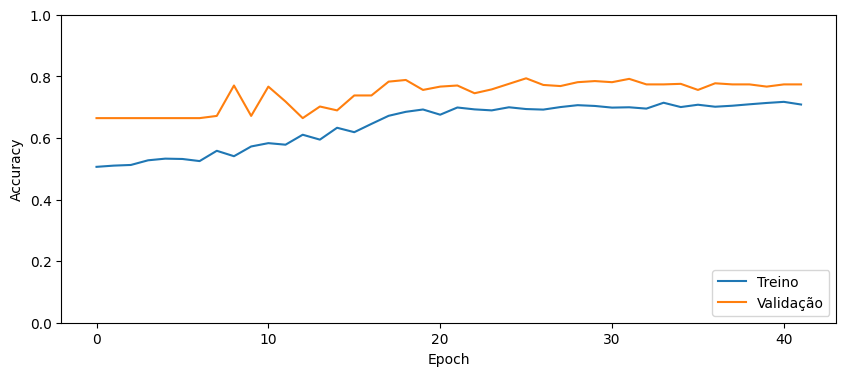

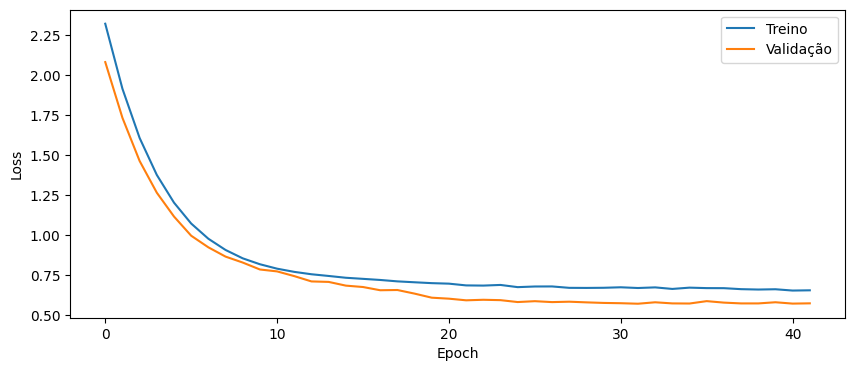

In [573]:
# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.plot(history_original.history['accuracy'], label='Treino')
plt.plot(history_original.history['val_accuracy'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Se quiseres visualizar também a perda, podes usar:
plt.plot(history_original.history['loss'], label='Treino')
plt.plot(history_original.history['val_loss'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.figure(figsize=(10, 4))
plt.plot(history_resampled.history['accuracy'], label='Treino')
plt.plot(history_resampled.history['val_accuracy'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 4))
# Se quiseres visualizar também a perda, podes usar:
plt.plot(history_resampled.history['loss'], label='Treino')
plt.plot(history_resampled.history['val_loss'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


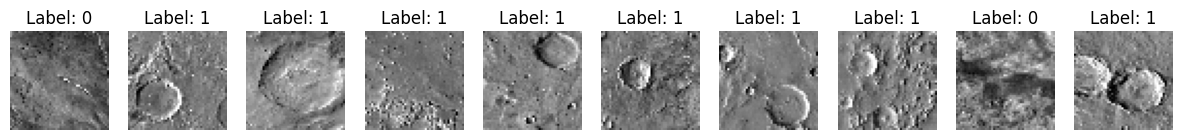

In [574]:
# Vamos mostrar as primeiras 10 imagens do conjunto de validação e seus rótulos correspondentes
# 0 - Sem cratera
# 1 - Com cratera

def visualizar_imagens_validacao(X_val, Y_val, num_imagens=10):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_imagens):
        plt.subplot(1, num_imagens, i + 1)
        plt.imshow(X_val[i].reshape(48, 48), cmap='gray')  # Exibimos a imagem em escala de cinza
        plt.title(f"Label: {Y_val[i]}")
        plt.axis('off')  # Desativa os eixos
        
    plt.show()

# Chamar a função para visualizar as primeiras 10 imagens e seus rótulos
visualizar_imagens_validacao(X_val, Y_val, num_imagens=10)


In [575]:
from sklearn.metrics import f1_score

# Fazer previsões no conjunto de validação (X_val)
# O modelo gera probabilidades, então usamos um limiar de 0.5 para classificar
Y_pred_val_orig = (model_orig.predict(X_val) > 0.5).astype("int32")
Y_pred_val_resampled = (model_resampled.predict(X_val) > 0.5).astype("int32")


# Calcular o F1 Score
f1 = f1_score(Y_val, Y_pred_val_orig)

print(f"F1 Score no conjunto de validação ORIGINAL: {f1:.4f}")

# Calcular o F1 Score
f1 = f1_score(Y_val, Y_pred_val_resampled)

print(f"F1 Score no conjunto de validação RESAMPLED: {f1:.4f}")




18/18 [==============================] - 0s 3ms/step
F1 Score no conjunto de validação ORIGINAL: 0.9065
F1 Score no conjunto de validação RESAMPLED: 0.8575


#### USING EXTRA UNLABELED DATA

In [576]:
# Step 3: Combine original labeled data with pseudo-labeled data

Y_pred_val_resampled = (model_resampled.predict(X_train_extra) > 0.5).astype("int32")

X_train_extra = X_train_extra.reshape(-1, 48, 48, 1)
Y_pred_val_resampled = Y_pred_val_resampled.flatten()

print("X_train_resampled shape:", X_train_resampled.shape)
print("X_train_extra shape:", X_train_extra.shape)
print("Y_train_resampled shape:", Y_train_resampled.shape)
print("Y_pred_val_resampled shape:", Y_pred_val_resampled.shape)

X_combined = np.concatenate([X_train_resampled, X_train_extra], axis=0)
Y_combined = np.concatenate([Y_train_resampled, Y_pred_val_resampled], axis=0)

combined_indices = np.arange(X_combined.shape[0])
np.random.shuffle(combined_indices)
X_combined = X_combined[combined_indices]
Y_combined = Y_combined[combined_indices]


X_combined_flat = X_combined.reshape(X_combined.shape[0], -1)

ros = RandomOverSampler(random_state=42)
X_combined_resampled, Y_combined_resampled = ros.fit_resample(X_combined_flat, Y_combined)

X_combined_resampled = X_combined_resampled.reshape(-1, 48, 48, 1)

optimizer = Adam(learning_rate=0.0001)
model_resampled.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



history_resampled = model_resampled.fit(
    X_combined_resampled, Y_combined_resampled, batch_size=32,
    validation_data=(X_val, Y_val),
    steps_per_epoch=len(X_combined_resampled) // 32,
    epochs=100,
    callbacks=callbacks
)

Y_pred_val_resampled = (model_resampled.predict(X_val) > 0.5).astype("int32")

f1 = f1_score(Y_val, Y_pred_val_resampled)

print(f"F1 Score no conjunto de validação RESAMPLED: {f1:.4f}")




29/29 [==============================] - 0s 3ms/step
X_train_resampled shape: (2814, 48, 48, 1)
X_train_extra shape: (904, 48, 48, 1)
Y_train_resampled shape: (2814,)
Y_pred_val_resampled shape: (904,)
Epoch 1/100
144/144 [==============================] - 2s 9ms/step - loss: 0.5274 - accuracy: 0.7572 - val_loss: 0.6970 - val_accuracy: 0.6068 - lr: 1.0000e-04
Epoch 2/100
144/144 [==============================] - 1s 8ms/step - loss: 0.5235 - accuracy: 0.7573 - val_loss: 0.7320 - val_accuracy: 0.5637 - lr: 1.0000e-04
Epoch 3/100
144/144 [==============================] - 1s 8ms/step - loss: 0.5163 - accuracy: 0.7675 - val_loss: 0.6776 - val_accuracy: 0.6607 - lr: 1.0000e-04
Epoch 4/100
144/144 [==============================] - 1s 9ms/step - loss: 0.5128 - accuracy: 0.7730 - val_loss: 0.6822 - val_accuracy: 0.6481 - lr: 1.0000e-04
Epoch 5/100
144/144 [==============================] - 1s 8ms/step - loss: 0.5097 - accuracy: 0.7712 - val_loss: 0.6418 - val_accuracy: 0.7020 - lr: 1.0000e-0

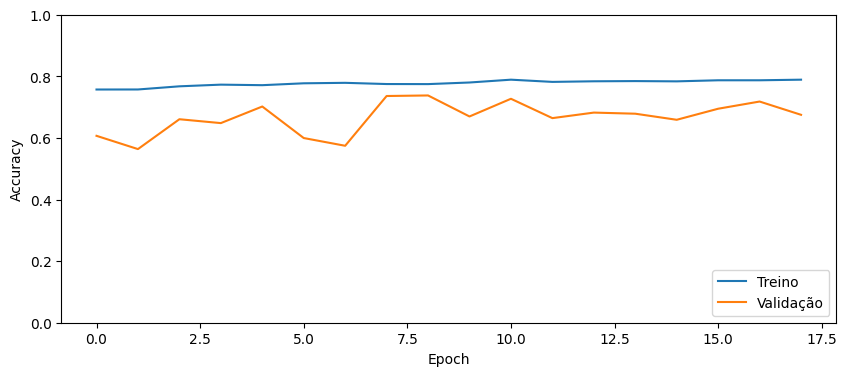

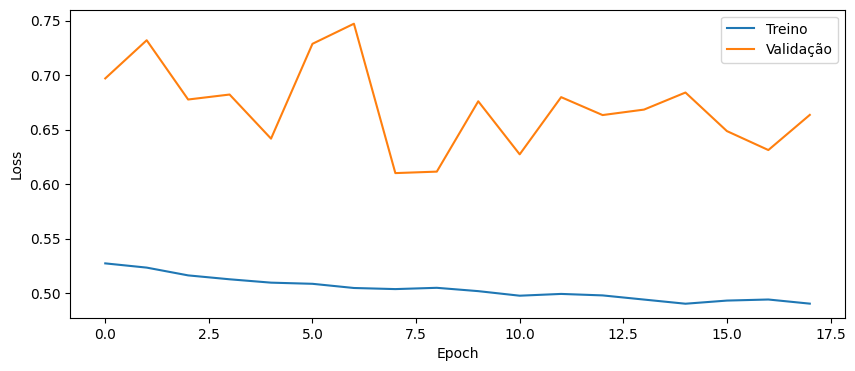

In [577]:

# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.figure(figsize=(10, 4))
plt.plot(history_resampled.history['accuracy'], label='Treino')
plt.plot(history_resampled.history['val_accuracy'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 4))
# Se quiseres visualizar também a perda, podes usar:
plt.plot(history_resampled.history['loss'], label='Treino')
plt.plot(history_resampled.history['val_loss'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
